In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os


In [2]:
# Function to plot cumulative distance
def plot_cumulative_distance(df, prefix=''):
    """
    Plots the cumulative distance against cumulative time for each maid in the dataframe.

    Parameters:
    df (pd.DataFrame): DataFrame containing maid, datetime, cumulative_distance(kms).
    """
    

    # Check and convert the datetime column if necessary
    if not pd.api.types.is_datetime64_any_dtype(df['datetime']):
        df['datetime'] = pd.to_datetime(df['datetime'])

    # Plotting cumulative distance against cumulative time
    plt.figure(figsize=(12, 6))

    for maid, group in df.groupby('maid'):
        plt.plot(group['datetime'], group['distance'], marker='o', linestyle='-', label=maid)

    plt.xlabel('Date')
    plt.ylabel('Distance (Kms)')

    # Adjusting the legend position and appearance
    plt.legend(
        loc='upper left',
        title='Maid ID',
        fancybox=True,
        framealpha=0.5,
        borderpad=1
    )

    plt.title(f'{prefix} Distance vs Time')

    # Set the x-axis major locator to day and format the dates
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    # ax.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
    # ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))


    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot the cumulative distance vs time using the sample data
# plot_cumulative_distance(df)


In [3]:
import pandas as pd
import geopandas as gpd
import folium
from datetime import datetime

def create_position_time(df, shapefile_path, save_path):
    # Load shapefile using GeoPandas
    gdf = gpd.read_file(shapefile_path)

    # Convert datetime to pandas datetime
    df['datetime'] = pd.to_datetime(df['datetime'])

    # Calculate time duration from a specific date (e.g., 2022-09-03)
    start_date = datetime(2022, 9, 3)
    df['time_duration'] = (df['datetime'] - start_date).dt.total_seconds() / 3600  # in hours
    max_duration = df['time_duration'].max()

    # Normalize time_duration to [0, 1] for heatmap intensity
    df['heatmap_intensity'] = df['time_duration'] / max_duration

    # Calculate bounding box based on dataframe coordinates
    min_lat, max_lat = df['latitude'].min(), df['latitude'].max()
    min_lon, max_lon = df['longitude'].min(), df['longitude'].max()

    # Calculate center of the bounding box
    center_lat = (min_lat + max_lat) / 2
    center_lon = (min_lon + max_lon) / 2

    # Create the map centered around the bounding box
    m = folium.Map(location=[center_lat, center_lon], zoom_start=10)

    # Uncomment if you want to add the GeoJSON layer
    # folium.GeoJson(gdf.to_json(), name="geojson").add_to(m)

    # Fit the map to the bounding box
    m.fit_bounds([[min_lat, min_lon], [max_lat, max_lon]])

    # Define VIBGYOR colors for markers
    vibgyor_colors = ['violet', 'indigo', 'blue', 'green', 'yellow', 'orange', 'red']

    # Define gradient colors for lines
    gradient_colors = ['green', 'lightgreen', 'yellow', 'orange', 'red', 'maroon']

    def get_gradient_color(speed):
        if speed > 600:
            return 'maroon'
        elif speed > 500:
            return 'red'
        elif speed > 400:
            return 'orange'
        elif speed > 300:
            return 'yellow'
        elif speed > 200:
            return 'lightgreen'
        else:
            return 'green'

    # Add lines connecting consecutive points with gradient colors
    for i in range(len(df) - 1):
        point1 = (df.iloc[i]['latitude'], df.iloc[i]['longitude'])
        point2 = (df.iloc[i + 1]['latitude'], df.iloc[i + 1]['longitude'])
        
        # Determine color index based on heatmap intensity for markers
        intensity_index = int(df.iloc[i + 1]['heatmap_intensity'] * (len(vibgyor_colors) - 1))
        marker_color = vibgyor_colors[intensity_index]

        # Determine color for lines based on instantaneous speed
        speed = df.iloc[i + 1]['Velocity']
        line_color = get_gradient_color(speed)
        # Add markers with tooltips for each point
        tooltip1 = f"Maid: {df.iloc[i]['maid']}<br>Lat: {df.iloc[i]['latitude']}<br>Lon: {df.iloc[i]['longitude']}<br>Date: {df.iloc[i]['datetime'].strftime('%Y-%m-%d %H:%M:%S')}<br>Displacement: {df.iloc[i]['displacement']}<br>Total Distance: {df.iloc[i]['distance']}<br>Inst. Speed(km/h): {df.iloc[i]['Velocity']}"
        folium.CircleMarker(
            location=point1,
            radius=5,
            color=marker_color,
            fill=True,
            fill_color=marker_color,
            fill_opacity=1,
            tooltip=tooltip1
        ).add_to(m)
        
        tooltip2 = f"Maid: {df.iloc[i+1]['maid']}<br>Lat: {df.iloc[i+1]['latitude']}<br>Lon: {df.iloc[i+1]['longitude']}<br>Date: {df.iloc[i+1]['datetime'].strftime('%Y-%m-%d %H:%M:%S')}<br>Displacement: {df.iloc[i+1]['displacement']}<br>Total Distance: {df.iloc[i+1]['distance']}<br>Inst. Speed(km/h): {df.iloc[i+1]['Velocity']}"
        folium.CircleMarker(
            location=point2,
            radius=5,
            color=marker_color,
            fill=True,
            fill_color=marker_color,
            fill_opacity=1,
            tooltip=tooltip2
        ).add_to(m)

        # Add polyline connecting consecutive points with gradient color
        folium.PolyLine(locations=[point1, point2], color=line_color, weight=2.5, opacity=1).add_to(m)
    # Add starting and ending points with star markers
    start_point = (df.iloc[0]['latitude'], df.iloc[0]['longitude'])
    end_point = (df.iloc[-1]['latitude'], df.iloc[-1]['longitude'])
    folium.Marker(
        location=start_point,
        icon=folium.Icon(color='silver', icon='star'),
        tooltip='Start Point'
    ).add_to(m)
    folium.Marker(
        location=end_point,
        icon=folium.Icon(color='black', icon='star'),
        tooltip='End Point'
    ).add_to(m)
    # Save map to an HTML file
    m.save(save_path)

# Actual usage
# shapefile_path = r'C:\Users\User\Downloads\Mobility_traces_new_data_code\GeoJSON files\India\Indian_States.shp'
# data_02a2 = data_dist[data_dist['maid']=='02a2c301-fb8c-4657-a346-a60fd50754d5']
# save_path = r'C:\Users\User\Downloads\Mobility_traces_new_data_code\validating_records\position_time_02a2c301-fb8c-4657-a346-a60fd50754d5.html'
# create_position_time(data_02a2, shapefile_path,save_path )


Queries to count problmetaic and good records

In [9]:
import numpy as np
data_dist = pd.read_csv(r"C:\Users\User\Downloads\Mobility_traces_new_data_code\all visitors\final_filtered_data_with_state_and_district.csv")
data_dist['datetime']= pd.to_datetime(data_dist['datetime'])
data_dist.shape
data_dist= data_dist.sort_values(by=['maid','datetime','latitude','longitude'])

data_dist.rename(columns={'Instantaneous_speed(km/h)':'Velocity', 'consecutive_distance(kms)':'displacement', 'cumulative_distance(kms)':'distance'}, inplace=True)
data_dist.columns  #Index(['maid', 'datetime', 'latitude', 'longitude', 'displacement', 'distance',
    #    'consecutive_time_gap(minutes)', 'cumulative_time(minutes)', 'Velocity',
    #    'state', 'district'],
    #   dtype='object')
# y= data_dist[(data_dist['Instantaneous_speed(km/h)']>10000)]
# # data_dist['Instantaneous_speed(km/h)'].dtype #float
# # Check if the values in the 'Inst_speed' column are infinite
is_infinite = np.isinf(data_dist['Velocity'])

# Filter the DataFrame to show only rows with infinite values
y = data_dist[is_infinite]
y['maid'].nunique()

49479

In [7]:
rec_with_velocity_600 = data_dist[data_dist['Velocity']>=400]
rec_with_velocity_600['maid'].nunique()

81437

In [8]:
rec_with_velocity_600_and_distance = data_dist[(data_dist['Velocity']>=600)& (data_dist['displacement']>=1) ]
rec_with_velocity_600_and_distance['maid'].nunique()

65019

In [72]:
rec_with_velocity_150_and_disp_10_50 = data_dist[(data_dist['Velocity']>=100)& (data_dist['displacement']>=10) & (data_dist['displacement']<=50) ]
ids  = rec_with_velocity_150_and_disp_10_50['maid'].unique().tolist()
print(len(ids))
ids.sort()
# rec_with_velocity_150_and_disp_10_50.count()
# Count records per 'maid' and sort from highest to lowest
recs = data_dist[data_dist['maid'].isin(set(ids))]
records_per_maid = rec_with_velocity_150_and_disp_10_50.groupby('maid').size().reset_index(name='count')
records_per_maid_sorted = records_per_maid.sort_values(by='count', ascending=False)
print(records_per_maid_sorted)

x = 16 # Replace this with your desired threshold value

# Filter the DataFrame to get records with count less than x
records_less_than_x = records_per_maid_sorted[records_per_maid_sorted['count'] == x]

# Number of maids with total count of records less than x
num_records_less_than_x = records_less_than_x.shape[0]

print(f'Number of maids with total count of records equal to {x} : {num_records_less_than_x}')

5527
                                      maid  count
4394  ccaa5e55-f1ef-48af-ae4d-61b64aa6f55d     26
4193  c375e2bc-4cb6-4480-b021-e28539bca297     21
2298  6abbb8ce-af43-4d17-8a40-69bdb95fda60     20
4361  caa3d1c0-80ef-4b36-8c98-70dd0799d809     18
1721  4ec77a97-1c77-44f0-816c-5b8af0446242     17
...                                    ...    ...
5513  ff659fa6-e89a-4239-aa98-8607e00843ee      1
5514  ff73963e-e1dc-426a-9a00-04ed85e3d25f      1
5499  fead9618-4006-4f38-923f-bc3b378e5955      1
5500  febd262d-04eb-4b5c-90ec-34c361522857      1
5501  fec62cda-a058-4541-8352-ea4878972729      1

[5527 rows x 2 columns]
Number of maids with total count of records equal to 16 : 4


In [73]:
few_ids = ids[0:20]
few_recs = recs[recs['maid'].isin(set(few_ids))]

In [75]:
few_recs.to_excel(r'C:\Users\User\Downloads\Mobility_traces_new_data_code\validating_records\few_recs_with_velocity_100_and_disp_10_50.xlsx')

In [9]:
# Step 1: Filter DataFrame where Velocity is higher than 600
high_velocity_records_with_high_displacement = data_dist[(data_dist['Velocity'] >= 600) & (data_dist['displacement']>=50)  ]

# Step 2: Group by 'maid' and count the number of such instances for each 'maid'
count_of_such_IDs = high_velocity_records_with_high_displacement.groupby('maid').size().reset_index(name='count')

# Step 3: Filter those groups to include only those where the count is 3 or more
maids_with_high_velocity = count_of_such_IDs[count_of_such_IDs['count'] >= 2]
maids_with_high_velocity['maid'].nunique()  #27845 for count of 3, 41744 for count of 2
# # Step 4: Filter the original DataFrame to include only rows for these 'maids' and where Distance is greater than 50 km
# filtered_records = data_dist[(data_dist['maid'].isin(maids_with_high_velocity)) & (data_dist['Distance'] > 50)]


41744

To find out the records transiting more than 100 kms with velocity>=600 but coming back in 50 kms range of the initial position within one hour

In [10]:
import pandas as pd
from geopy.distance import geodesic
from tqdm import tqdm

def calculate_distances_and_time_gaps_continous_invalid_stamps(data, displacement_threshold, velocity_threshold, time_window, distance_range):
    # Convert 'datetime' column to datetime format
    data['datetime'] = pd.to_datetime(data['datetime'])
    # col_name = f'keep_for_{displacement_threshold}_{velocity_threshold}_{time_window}_{distance_range}'
    # Initialize new columns
    data['dist_previous_next'] = None
    data['time_gap_previous_next'] = None
    data['next_valid_index'] = None
    data['keep'] = True
    
    # Sort data by 'maid', 'datetime', 'latitude', and 'longitude', and reset index
    data = data.sort_values(by=['maid', 'datetime', 'latitude', 'longitude']).reset_index(drop=True)
    
    # Maintain a mapping from the original index to the new sorted index
    original_to_sorted_index = data.reset_index().set_index('index').index
    # Initialize the progress bar
    tqdm.pandas(desc="Processing maids")

    # Calculate distance and time gap
    for maid, group in tqdm(data.groupby('maid'), desc="Processing each maid"):
    # Calculate distance and time gap
    # for maid, group in data.groupby('maid'):
        num_records = len(group)
        for i in range(1, num_records - 1):
        # for i in range(1, num_records - 1):
            displacement = group.loc[group.index[i], 'displacement']
            # print(f'group.index[i]: {group.index[i]}')
            # print(f'disalcement:{displacement}')
            velocity = group.loc[group.index[i], 'Velocity']
            # print(f'disalcement:{displacement}, velocity { {velocity}}')
            if (displacement >= displacement_threshold) and (velocity >= velocity_threshold):
                # print(f'Inside if: disalcement:{displacement}, velocity { {velocity}}')
                # print(f'index: {group.index[i]}')
                prev_record = group.loc[group.index[i - 1]]
                next_valid_index = None
                
                for j in range(i + 1, num_records):
                    next_record = group.loc[group.index[j]]
                    time_gap = (next_record['datetime'] - prev_record['datetime']).total_seconds() / 60
                    
                    if time_gap > time_window:
                        break
                    
                    distance = geodesic(
                        (prev_record['latitude'], prev_record['longitude']),
                        (next_record['latitude'], next_record['longitude'])
                    ).kilometers
                    
                    if distance < distance_range:
                        next_valid_index = j
                        break

                if next_valid_index is not None:
                    original_index = group.index[i]
                    sorted_next_valid_index = group.index[next_valid_index]

                    # Convert sorted index back to original index
                    original_next_valid_index = original_to_sorted_index.get_loc(sorted_next_valid_index)

                    # Update the current record (i) with information about the next valid index
                    data.at[original_index, 'next_valid_index'] = original_next_valid_index
                    data.at[original_index, 'dist_previous_next'] = distance
                    data.at[original_index, 'time_gap_previous_next'] = time_gap

                    # Mark records between the current index and one record before the next valid index as False
                    if original_next_valid_index > original_index:
                        indices_to_mark = range(original_index , original_next_valid_index)
                        data.loc[indices_to_mark, 'keep'] = False

    return data

def filter_out_continuos_invalid_stamps(data):
    filtered_data = data[data['keep'] == True]
    return filtered_data

In [4]:
import pandas as pd
from geopy.distance import geodesic
from tqdm import tqdm

def calculate_distances_and_time_gaps_continous_invalid_stamps_looking_backward(data, displacement_threshold, velocity_threshold, time_window, distance_range):
    # Convert 'datetime' column to datetime format
    data['datetime'] = pd.to_datetime(data['datetime'])
    # col_name = f'keep_for_{displacement_threshold}_{velocity_threshold}_{time_window}_{distance_range}'
    # Initialize new columns
    data['dist_previous_next'] = None
    data['time_gap_previous_next'] = None
    data['prev_valid_index'] = None
    data['keep'] = True
    
    # Sort data by 'maid', 'datetime', 'latitude', and 'longitude', and reset index
    data = data.sort_values(by=['maid', 'datetime', 'latitude', 'longitude']).reset_index(drop=True)
    
    # Maintain a mapping from the original index to the new sorted index
    original_to_sorted_index = data.reset_index().set_index('index').index
    # Initialize the progress bar
    tqdm.pandas(desc="Processing maids")

    # Calculate distance and time gap
    for maid, group in tqdm(data.groupby('maid'), desc="Processing each maid"):
    # Calculate distance and time gap
    # for maid, group in data.groupby('maid'):
        num_records = len(group)
        for i in range(1, num_records - 1):
        # for i in range(1, num_records - 1):
            displacement = group.loc[group.index[i], 'displacement']
            # print(f'group.index[i]: {group.index[i]}')
            # print(f'disalcement:{displacement}')
            velocity = group.loc[group.index[i], 'Velocity']
            # print(f'disalcement:{displacement}, velocity { {velocity}}')
            if (displacement >= displacement_threshold) and (velocity >= velocity_threshold):
                # print(f'Inside if: disalcement:{displacement}, velocity { {velocity}}')
                # print(f'index: {group.index[i]}')
                curr_record = group.loc[group.index[i]]
                prev_valid_index = None
                
                for j in range(i - 1, 0,-1):
                    prev_record = group.loc[group.index[j]]
                    # print(f'prev_record= {prev_record}')
                    # print(f'index of prev_record: {j}')
                    time_gap = (curr_record['datetime'] - prev_record['datetime']).total_seconds() / 60
                    # print(f'time_gap:{time_gap} {type(time_gap)}')
                    # print(f'time_window: {time_window} {type(time_window)}')
                    if time_gap > time_window:
                        
                        # print('break due to time gap')
                        break
                    
                    distance = geodesic(
                        (prev_record['latitude'], prev_record['longitude']),
                        (curr_record['latitude'], curr_record['longitude'])
                    ).kilometers
                    
                    if distance < distance_range:
                        prev_valid_index = j
                        # print('break due to distance')
                        break

                if prev_valid_index is not None:
                    original_index = group.index[i]
                    sorted_previous_valid_index = group.index[prev_valid_index]

                    # Convert sorted index back to original index
                    original_previous_valid_index = original_to_sorted_index.get_loc(sorted_previous_valid_index)
                    # print(f'original_index: {original_index}')
                    # print(f'original_previous_valid_index: {original_previous_valid_index}')
                    # Update the current record (i) with information about the next valid index
                    data.at[original_index, 'prev_valid_index'] = original_previous_valid_index
                    data.at[original_index, 'dist_previous_next'] = distance
                    data.at[original_index, 'time_gap_previous_next'] = time_gap

                    # Mark records between the one record previous to current index and one record later than the previous valid index as False
                    if original_previous_valid_index < original_index:
                        indices_to_mark = range(original_previous_valid_index + 1, original_index )
                        # print(f'indices_to_mark: {indices_to_mark}')
                        data.loc[indices_to_mark, 'keep'] = False

    return data

def filter_out_continuos_invalid_stamps(data):
    filtered_data = data[data['keep'] == True]
    return filtered_data

In [ ]:
df_temp

In [201]:
step =2
print(df_temp.shape)
displacement_min_threshold, min_velocity_threshold, dist_prev_next_threshold, time_gap_pre_next_threshold, sub_folder_name = params(step)
# Print the variables with proper formatting
print(f"Displacement Minimum Threshold: {displacement_min_threshold}")
print(f"Minimum Velocity Threshold: {min_velocity_threshold}")
print(f"Distance Previous-Next Threshold: {dist_prev_next_threshold}")
print(f"Time Gap Previous-Next Threshold: {time_gap_pre_next_threshold}")
df_temp_stg1 = calculate_distances_and_time_gaps_continous_invalid_stamps_looking_backward(df_temp,
                                                                                                          displacement_min_threshold, 
                                                                                                          min_velocity_threshold, 
                                                                                                          dist_prev_next_threshold, 
                                                                                                          time_gap_pre_next_threshold )
# df_temp_stg1.to_excel(r'C:\Users\User\Downloads\Mobility_traces_new_data_code\validating_records\whole data type 2 issue\rec_with_type_2_filtered.xlsx',index=False)
df_temp_stg1[['maid','datetime', 'latitude','longitude','displacement','Velocity','state', 'district', 'prev_valid_index', 'keep']]

(35, 15)
Displacement Minimum Threshold: 100
Minimum Velocity Threshold: 150
Distance Previous-Next Threshold: 100
Time Gap Previous-Next Threshold: 120


Processing each maid: 100%|██████████| 1/1 [00:00<00:00, 373.16it/s]


maid            datetime  latitude  \
0   55333706-57fa-4bbe-8817-9c5db8d12e25 2022-09-04 16:39:11   29.4046   
1   55333706-57fa-4bbe-8817-9c5db8d12e25 2022-09-07 03:39:40   29.4046   
2   55333706-57fa-4bbe-8817-9c5db8d12e25 2022-09-08 03:54:30   29.4045   
3   55333706-57fa-4bbe-8817-9c5db8d12e25 2022-09-08 03:54:31   29.4045   
4   55333706-57fa-4bbe-8817-9c5db8d12e25 2022-09-08 13:00:05   29.6678   
5   55333706-57fa-4bbe-8817-9c5db8d12e25 2022-09-08 14:36:36   29.5403   
6   55333706-57fa-4bbe-8817-9c5db8d12e25 2022-09-08 16:14:30   28.6327   
7   55333706-57fa-4bbe-8817-9c5db8d12e25 2022-09-08 16:14:31   29.5348   
8   55333706-57fa-4bbe-8817-9c5db8d12e25 2022-09-08 18:26:41   29.5348   
9   55333706-57fa-4bbe-8817-9c5db8d12e25 2022-09-09 12:51:43   29.4046   
10  55333706-57fa-4bbe-8817-9c5db8d12e25 2022-09-09 14:08:30   29.3812   
11  55333706-57fa-4bbe-8817-9c5db8d12e25 2022-09-09 15:35:47   29.3812   
12  55333706-57fa-4bbe-8817-9c5db8d12e25 2022-09-09 21:49:50   28.6327   
13  55333706-57fa-4bbe-8817-9c5db8d12e25 2022-09-10 05:43:00   29.4325   
14  55333706-57fa-4bbe-8817-9c5db8d12e25 2022-09-10 06:27:57   29.4325   
15  55333706-57fa-4bbe-8817-9c5db8d12e25 2022-09-10 10:14:34   29.4354   
16  55333706-57fa-4bbe-8817-9c5db8d12e25 2022-09-10 12:49:23   29.4354   
17  55333706-57fa-4bbe-8817-9c5db8d12e25 2022-09-10 13:52:11   29.4166   
18  55333706-57fa-4bbe-8817-9c5db8d12e25 2022-09-10 17:47:49   29.4166   
19  55333706-57fa-4bbe-8817-9c5db8d12e25 2022-09-10 21:12:11   29.4046   
20  55333706-57fa-4bbe-8817-9c5db8d12e25 2022-09-10 21:12:13   28.6327   
21  55333706-57fa-4bbe-8817-9c5db8d12e25 2022-09-11 14:34:07   29.4045   
22  55333706-57fa-4bbe-8817-9c5db8d12e25 2022-09-11 16:30:22   29.4045   
23  55333706-57fa-4bbe-8817-9c5db8d12e25 2022-09-11 21:55:50   29.4046   
24  55333706-57fa-4bbe-8817-9c5db8d12e25 2022-09-11 21:55:51   29.4046   
25  55333706-57fa-4bbe-8817-9c5db8d12e25 2022-09-12 11:07:01   29.4052   
26  55333706-57fa-4bbe-8817-9c5db8d12e25 2022-09-12 11:07:52   29.4052   
27  55333706-57fa-4bbe-8817-9c5db8d12e25 2022-09-12 12:51:02   29.4052   
28  55333706-57fa-4bbe-8817-9c5db8d12e25 2022-09-12 12:51:51   29.4052   
29  55333706-57fa-4bbe-8817-9c5db8d12e25 2022-09-12 15:36:38   29.4051   
30  55333706-57fa-4bbe-8817-9c5db8d12e25 2022-09-12 18:26:54   29.4051   
31  55333706-57fa-4bbe-8817-9c5db8d12e25 2022-09-13 03:54:26   29.4045   
32  55333706-57fa-4bbe-8817-9c5db8d12e25 2022-09-13 18:26:43   29.4045   
33  55333706-57fa-4bbe-8817-9c5db8d12e25 2022-09-14 03:17:19   29.4046   
34  55333706-57fa-4bbe-8817-9c5db8d12e25 2022-09-14 17:19:18   29.4046   

    longitude  displacement       Velocity          state           district  \
0     78.3884      0.000000       0.000000  Uttar Pradesh            Outside   
1     78.3884      0.000000       0.000000  Uttar Pradesh            Outside   
2     78.3884      0.011119       0.000459  Uttar Pradesh            Outside   
3     78.3884      0.000000       0.000000  Uttar Pradesh            Outside   
4     78.0832     41.581085       4.572979    Uttarakhand  Haridwar District   
5     78.1389     15.165622       9.427774  Uttar Pradesh            Outside   
6     77.2198    134.762636      82.592014   NCT of Delhi            Outside   
7     78.1383    134.268093  483365.136073  Uttar Pradesh            Outside   
8     78.1383      0.000000       0.000000  Uttar Pradesh            Outside   
9     78.3885     28.218344       1.532172  Uttar Pradesh            Outside   
10    78.1318     25.005174      19.539532  Uttar Pradesh            Outside   
11    78.1318      0.000000       0.000000  Uttar Pradesh            Outside   
12    77.2198    121.624923      19.509412   NCT of Delhi            Outside   
13    78.3574    141.919618      17.996147  Uttar Pradesh            Outside   
14    78.3574      0.000000       0.000000  Uttar Pradesh            Outside   
15    78.4255      6.602832       1.748194  Uttar Pradesh            Outside   
16    78.42

In [133]:
data_10_15.shape
data_10_15_subset = data_10_15.iloc[14:17]
data_10_15_prev_next_gap_removed_invalid_stamps = calculate_distances_and_time_gaps_continous_invalid_stamps(data_10_15, 100,400,120,10)
# data_10_15_prev_next_gap

In [134]:
data_10_15_prev_next_gap_removed_invalid_stamps =filter_out_continuos_invalid_stamps(data_10_15_prev_next_gap_removed_invalid_stamps)

In [75]:
prev_record = data_10_15.iloc[14]
next_record = data_10_15.iloc[15]
print(prev_record['datetime'])
print(next_record['datetime'])
print(next_record['datetime'] - prev_record['datetime'])
print((next_record['datetime'] - prev_record['datetime']).total_seconds())

2022-09-07 08:35:47
2022-09-08 02:50:13
0 days 18:14:26
65666.0


In [137]:
data_10_15.shape
data_10_15_prev_next_gap_removed_invalid_stamps.shape

(1018, 14)

In [122]:
data_10_15_prev_next_gap_removed_single_invalid_records = calculate_distance_time_gap_vectorized_single_invalid_timestamp(data_10_15, 100,400 )
data_10_15_prev_next_gap_removed_single_invalid_records = filter_out_records_single_invalid_records(data_10_15, 10, 120)  # dataframe, distance_between previpus and next(km), time(minutes)
print(f'data_10_15_prev_next_gap_removed_single_invalid_records shape after filtering records: {data_10_15_prev_next_gap_removed_single_invalid_records.shape}')

# print(f' NaN count after filter_records : {nan_count}')
# print(f'Filtered {count} times...')
data_10_15_prev_next_gap_removed_single_invalid_records = optimized_function_maid_vectorized(data_10_15_prev_next_gap_removed_single_invalid_records)
   

data_10_15_prev_next_gap_removed_single_invalid_records shape after filtering records: (1047, 14)


In [138]:
data_10_15_prev_next_gap_removed_invalid_stamps= optimized_function_maid_vectorized(data_10_15_prev_next_gap_removed_invalid_stamps)
data_10_15_prev_next_gap_removed_invalid_stamps.to_excel(r'C:\Users\User\Downloads\Mobility_traces_new_data_code\validating_records\data_10_15_prev_next_gap_removed_invalid_stamps.xlsx') #original

In [5]:
import warnings
warnings.filterwarnings("ignore")

1.Store backup of original Latitude and longitude as original_latitude and original_longitude and round of lat and long upto 2 decimal points


2. Remove the points not changing with time.

3. Compute distance, displacement and velocity again


Don't round off Lat and long to 2 digits. keep it upto 4 digits
Just apply the logic defined to remove the invalid points

then apply the below logic to remove invalid timestamps

In [13]:
#step 1
print(data_dist.columns)

data_dist.head()

Index(['maid', 'datetime', 'latitude', 'longitude', 'displacement', 'distance',
       'consecutive_time_gap(minutes)', 'cumulative_time(minutes)', 'Velocity',
       'state', 'district'],
      dtype='object')


maid            datetime  latitude  \
0  000010b7-6bd5-4296-9235-2a824209b773 2022-09-03 08:08:03   30.4418   
1  000010b7-6bd5-4296-9235-2a824209b773 2022-09-03 08:08:54   30.4418   
2  000010b7-6bd5-4296-9235-2a824209b773 2022-09-03 08:38:14   30.4368   
3  000010b7-6bd5-4296-9235-2a824209b773 2022-09-03 08:38:23   30.4368   
4  000010b7-6bd5-4296-9235-2a824209b773 2022-09-03 10:07:56   30.4367   

   longitude  displacement  distance  consecutive_time_gap(minutes)  \
0    77.6110      0.000000  0.000000                       0.000000   
1    77.6110      0.000000  0.000000                       0.850000   
2    77.5827      2.769460  2.769460                      29.333333   
3    77.5827      0.000000  2.769460                       0.150000   
4    77.5827      0.011119  2.780579                      89.550000   

   cumulative_time(minutes)  Velocity             state district  
0                  0.000000  0.000000  Himachal Pradesh  Outside  
1                  0.850000  0.000000  Himachal Pradesh  Outside  
2                 30.183333  5.664804  Himachal Pradesh  Outside  
3                 30.333333  0.000000  Himachal Pradesh  Outside  
4                119.883333  0.007450  Himachal Pradesh  Outside

In [6]:
# Step 2

import pandas as pd

def remove_unnecessary_timestamps(df):
    """
    Filters the dataframe to keep only the first and last records where latitude and longitude remain the same
    across consecutive timestamps for each maid.

    Parameters:
    df (pd.DataFrame): Input dataframe containing 'maid', 'datetime', 'latitude', and 'longitude' columns.

    Returns:
    pd.DataFrame: Filtered dataframe with only the first and last records where coordinates remain the same for each maid.
    """
    # Round latitude and longitude to 4 decimal places
    df['latitude'] = df['latitude'].astype(float).round(4)
    df['longitude'] = df['longitude'].astype(float).round(4)
    # Sort by 'maid' and 'datetime' to ensure consecutive timestamps are in order within each maid
    df = df.sort_values(by=['maid', 'datetime','latitude','longitude']).reset_index(drop=True)

    # Identify and keep first and last records where lat and long remain the same within each maid
    df['prev_lat'] = df.groupby('maid')['latitude'].shift(1)
    df['prev_long'] = df.groupby('maid')['longitude'].shift(1)
    df['next_lat'] = df.groupby('maid')['latitude'].shift(-1)
    df['next_long'] = df.groupby('maid')['longitude'].shift(-1)

    # Filter to keep rows where latitude or longitude changes within each maid
    filtered_df = df[(df['latitude'] != df['prev_lat']) |
                     (df['longitude'] != df['prev_long']) |
                     (df['latitude'] != df['next_lat']) |
                     (df['longitude'] != df['next_long'])]
    filtered_df.drop(['prev_lat', 'prev_long', 'next_lat', 'next_long'], axis=1, inplace=True)
    # Drop records for maids with only one record
    # Count occurrences of each maid
    maid_counts = df['maid'].value_counts()
    maid_single_records = maid_counts[maid_counts == 1].index
    filtered_df = filtered_df[~filtered_df['maid'].isin(maid_single_records)]

    return filtered_df



In [7]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic


def filter_out_records_single_invalid_records(data, dist_threshold, time_gap_threshold):
    """
    Filter records based on distance and time gap thresholds.

    Parameters:
    data (pd.DataFrame): DataFrame containing maid, datetime, latitude, longitude, displacement, and Velocity.
    dist_threshold (float): Distance threshold for filtering.
    time_gap_threshold (float): Time gap threshold for filtering.

    Returns:
    pd.DataFrame: Filtered DataFrame.
    """
    filtered_data = data[~((data['dist_previous_next'] < dist_threshold) & (data['time_gap_previous_next'] < time_gap_threshold))]
    return filtered_data
    
def calculate_distance_time_gap_vectorized_single_invalid_timestamp(data, displacement_threshold, velocity_threshold):
    data['datetime'] = pd.to_datetime(data['datetime'])
    data = data.sort_values(by=['maid', 'datetime'])
    
    # Calculate displacement and velocity
    data = optimized_function_maid_vectorized(data)

    # Shift indices for previous and next records
    data['prev_idx'] = data.index - 1
    data['next_idx'] = data.index + 1

    valid_prev = data['prev_idx'].isin(data.index)
    valid_next = data['next_idx'].isin(data.index)
    
    # Initialize new columns
    data['dist_previous_next'] = np.nan
    data['time_gap_previous_next'] = np.nan

    # Calculate distance and time gap for valid records
    mask = (data['displacement'] >= displacement_threshold) & (data['Velocity'] >= velocity_threshold)
    valid_mask = mask & valid_prev & valid_next
    data_valid = data.loc[valid_mask]

    distances = [
        geodesic(
            (data.at[idx - 1, 'latitude'], data.at[idx - 1, 'longitude']),
            (data.at[idx + 1, 'latitude'], data.at[idx + 1, 'longitude'])
        ).kilometers
        for idx in data_valid.index
    ]

    time_gaps = [
        (data.at[idx + 1, 'datetime'] - data.at[idx - 1, 'datetime']).total_seconds() / 60
        for idx in data_valid.index
    ]

    data.loc[valid_mask, 'dist_previous_next'] = distances
    data.loc[valid_mask, 'time_gap_previous_next'] = time_gaps

    # Drop the temporary index columns
    data = data.drop(columns=['prev_idx', 'next_idx'])

    return data







In [8]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic
from tqdm import tqdm

def calculate_distances_and_time_gaps_continous_invalid_stamps_vector(data, displacement_threshold, velocity_threshold, time_window, distance_range):
    # Convert 'datetime' column to datetime format
    data['datetime'] = pd.to_datetime(data['datetime'])
    
    # Initialize new columns
    data['dist_previous_next'] = np.nan
    data['time_gap_previous_next'] = np.nan
    data['next_valid_index'] = np.nan
    data['keep'] = True
    
    # Sort data by 'maid', 'datetime', 'latitude', and 'longitude'
    data = data.sort_values(by=['maid', 'datetime', 'latitude', 'longitude']).reset_index(drop=True)

    # Initialize the progress bar
    tqdm.pandas(desc="Processing maids")

    def process_group(group):
        # Filter by displacement and velocity thresholds
        valid_mask = (group['displacement'] >= displacement_threshold) & (group['Velocity'] >= velocity_threshold)
        valid_indices = group.index[valid_mask]

        if valid_indices.empty:
            return group

        prev_latitudes = group['latitude'].shift(1)
        prev_longitudes = group['longitude'].shift(1)
        next_latitudes = group['latitude'].shift(-1)
        next_longitudes = group['longitude'].shift(-1)
        group['dist_previous_next'] = group.apply(lambda row: geodesic(
            (prev_latitudes[row.name], prev_longitudes[row.name]),
            (next_latitudes[row.name], next_longitudes[row.name])
        ).kilometers if pd.notnull(prev_latitudes[row.name]) and pd.notnull(next_latitudes[row.name]) else np.nan, axis=1)

        group['time_gap_previous_next'] = (
            group['datetime'].shift(-1) - group['datetime'].shift(1)
        ).dt.total_seconds() / 60

        for i in valid_indices:
            next_valid_idx = group.index[(group.index > i) & (group['time_gap_previous_next'] <= time_window) & (group['dist_previous_next'] < distance_range)].min()
            
            if pd.notnull(next_valid_idx):
                group.at[i, 'next_valid_index'] = next_valid_idx
                group.loc[i:next_valid_idx-1, 'keep'] = False

        return group

    # Apply the process_group function to each group
    data = data.groupby('maid').progress_apply(process_group)

    return data

def filter_out_continuos_invalid_stamps(data):
    return data[data['keep'] == True]

# Example usage:
# data = pd.read_csv('your_data.csv')
# displacement_threshold = 200
# velocity_threshold = 400
# time_window = 120
# distance_range = 10

# updated_data = calculate_distances_and_time_gaps_continous_invalid_stamps_vector(data, displacement_threshold, velocity_threshold, time_window, distance_range)
# filtered_data = filter_out_continuos_invalid_stamps(updated_data)
# print(filtered_data)


In [9]:
import pandas as pd
import numpy as np

def optimized_function_maid_vectorized(df, lat_col='latitude', lon_col='longitude', datetime_col='datetime', maid_col='maid'):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.sort_values(by=[maid_col, datetime_col, lat_col, lon_col])

    # Shift columns to get previous values for each maid
    df['prev_X'] = df.groupby(maid_col)[lon_col].shift(1)
    df['prev_Y'] = df.groupby(maid_col)[lat_col].shift(1)
    df['prev_datetime'] = df.groupby(maid_col)[datetime_col].shift(1)

    # Radius of the Earth in kilometers
    R = 6371

    # Convert latitude and longitude from degrees to radians
    lat1 = np.radians(df[lat_col].values)
    lat2 = np.radians(df['prev_Y'].values)
    dlat = lat2 - lat1
    dlon = np.radians(df['prev_X'].values) - np.radians(df[lon_col].values)

    # Haversine formula for distance calculation
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # Calculate consecutive distance in kilometers
    df['displacement'] = R * c
    df['distance'] = df.groupby(maid_col)['displacement'].cumsum()

    # Calculate consecutive time gap in minutes
    df['consecutive_time_gap(minutes)'] = (df[datetime_col] - df['prev_datetime']).dt.total_seconds() / 60

    # Calculate velocity
    df['Velocity'] = df['displacement'] / (df['consecutive_time_gap(minutes)'] / 60)

    # Drop temporary columns
    df = df.drop(columns=['prev_X', 'prev_Y', 'prev_datetime', 'consecutive_time_gap(minutes)'])

    # Fill NaN values with 0
    df = df.fillna(0)

    return df

# Test the performance of both functions
import time


def optimized_function_maid(df, lat_col='latitude', lon_col='longitude', datetime_col='datetime', maid_col='maid'):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.sort_values(by=[maid_col, datetime_col, lat_col, lon_col])

    # Shift columns to get previous values for each maid
    df['prev_X'] = df.groupby(maid_col)[lon_col].shift(1)
    df['prev_Y'] = df.groupby(maid_col)[lat_col].shift(1)
    df['prev_datetime'] = df.groupby(maid_col)[datetime_col].shift(1)

    # Radius of the Earth in kilometers
    R = 6371

    # Convert latitude and longitude from degrees to radians
    lat1 = np.radians(df[lat_col].values)
    lat2 = np.radians(df['prev_Y'].values)
    dlat = lat2 - lat1
    dlon = np.radians(df['prev_X'].values) - np.radians(df[lon_col].values)

    # Haversine formula for distance calculation
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # Calculate consecutive distance in kilometers
    df['displacement'] = R * c
    df['distance'] = df.groupby(maid_col)['displacement'].cumsum()

    # Calculate consecutive time gap in minutes
    df['consecutive_time_gap(minutes)'] = (df[datetime_col] - df['prev_datetime']).dt.total_seconds() / 60

    # Calculate cumulative time in minutes
    df['Velocity'] = df['displacement'] / (df['consecutive_time_gap(minutes)'] / 60)
    
    # Drop temporary columns
    df = df.drop(columns=['prev_X', 'prev_Y', 'prev_datetime', 'consecutive_time_gap(minutes)'])

    # Fill NaN values with 0
    df = df.fillna(0)

    return df


In [10]:
def check_condition(data, displacement, time_gap_in_min):
    """
    Check if there are records satisfying dist_previous_next < 50 and time_gap_previous_next < 60.

    Parameters:
    data (pd.DataFrame): DataFrame containing dist_previous_next and time_gap_previous_next columns.

    Returns:
    bool: True if such records exist, False otherwise.
    """
    condition = (data['dist_previous_next'] <= displacement) & (data['time_gap_previous_next'] <= time_gap_in_min)
    return not data[condition].empty

# Example usage
# flag = check_condition(data_new)

In [15]:
data_dist= optimized_function_maid_vectorized(data_dist)


In [17]:
data_dist.shape

(3726391, 10)

In [16]:
#take some sample IDs
import json
with open(r'C:\Users\User\Downloads\Mobility_traces_new_data_code\validating_records\IDs_for_both_good_and_bad_sorted.json','r') as f:
    sample_ids = json.load(f)

In [31]:

flag= True
start_index=0
end_index= 10
curr_ids = sample_ids[start_index:end_index]
data_new = data_dist[data_dist['maid'].isin(set(curr_ids))]
print(f'data_new columns : {data_new.columns}')
folder_name = f'ID_{start_index}_to_{end_index}'

data_new columns : Index(['maid', 'datetime', 'latitude', 'longitude', 'displacement', 'distance',
       'cumulative_time(minutes)', 'Velocity', 'state', 'district'],
      dtype='object')


In [154]:
import os

base_path = fr'C:\Users\User\Downloads\Mobility_traces_new_data_code\validating_records\{folder_name}'
folder_path = base_path


# Function to create a directory if it doesn't exist
def create_directory(path):
    if not os.path.exists(path):
        os.makedirs(path, exist_ok=True)

# Create the main directory
create_directory(base_path)


# Define and create sub-directories
path_individual_orig_rec = os.path.join(base_path, 'Orig_rec')
path_position_time_plots_orig = os.path.join(base_path, 'orig_pos_time')

create_directory(path_individual_orig_rec)
create_directory(path_position_time_plots_orig)


print("Directories are created or already exist.")



Directories are created or already exist.


In [150]:
# plotting origianl position_time_plot
grouped = data_new.groupby('maid')
for maid, group in grouped:
    group['datetime']= pd.to_datetime(group['datetime'])
    group=group.sort_values(by=['datetime'])
    group.to_csv(fr'{path_individual_orig_rec}\{maid}.csv', index=False)
    group.to_excel(fr'{path_individual_orig_rec}\{maid}.xlsx', index=False)
    shapefile_path = r'C:\Users\User\Downloads\Mobility_traces_new_data_code\GeoJSON files\India\Indian_States.shp'
    
    save_path = fr'{path_position_time_plots_orig}\pos_time_{maid}.html'
    create_position_time(group, shapefile_path,save_path )

In [14]:
# determine parameters:
displacement_min_threshold = 50   # distance covered during invalid transition
min_velocity_threshold = 150       # minimum speed during the invalid transition
dist_prev_next_threshold = 50      # maximum permittted distance between previos and next location for the invalid transition stamp
time_gap_pre_next_threshold = 60 # Time gap(min) between previuos and next time stamp for the invalid record
sub_folder_name = f'threshold_dist_{displacement_min_threshold}_vel_{min_velocity_threshold}_dist_prev_next_{dist_prev_next_threshold}_time_gap_{time_gap_pre_next_threshold}_min'


In [76]:
ids_with_issue = data_dist[(data_dist['Velocity']>=150) & (data_dist['displacement']>=50)]['maid'].unique().tolist()
ids_with_issue = set(ids_with_issue)
rec_with_issue = data_dist[data_dist['maid'].isin(ids_with_issue)]
rec_with_issue.shape

(2824507, 10)

In [77]:
len(ids_with_issue)

71327

In [78]:
# rec_with_issue = pd.read_csv(r'C:\Users\User\Downloads\Mobility_traces_new_data_code\validating_records\Whole data issue records\1_filtered_threshold_dist_50_vel_150_dist_prev_next_50_time_gap_60_min.csv')
rec_with_issue['datetime'] = pd.to_datetime(rec_with_issue['datetime'])
print(rec_with_issue.shape)
rec_with_issue= rec_with_issue.sort_values(by=['maid','datetime','latitude','longitude'])
rec_with_issue.columns

(2824507, 10)


Index(['maid', 'datetime', 'latitude', 'longitude', 'displacement', 'distance',
       'cumulative_time(minutes)', 'Velocity', 'state', 'district'],
      dtype='object')

In [11]:
def params(step):

    # determine parameters:
    if step==1:
        displacement_min_threshold = 50   # distance covered during invalid transition
        min_velocity_threshold = 150       # minimum speed during the invalid transition
        dist_prev_next_threshold = 50      # maximum permittted distance between previos and next location for the invalid transition stamp
        time_gap_pre_next_threshold = 60 # Time gap(min) between previuos and next time stamp for the invalid record
        sub_folder_name = f'threshold_dist_{displacement_min_threshold}_vel_{min_velocity_threshold}_dist_prev_next_{dist_prev_next_threshold}_time_gap_{time_gap_pre_next_threshold}_min'
    elif step==2:
        displacement_min_threshold = 100   # distance covered during invalid transition
        min_velocity_threshold = 150       # minimum speed during the invalid transition
        dist_prev_next_threshold = 100      # maximum permittted distance between previos and next location for the invalid transition stamp
        time_gap_pre_next_threshold = 120 # Time gap(min) between previuos and next time stamp for the invalid record
        sub_folder_name = f'threshold_dist_{displacement_min_threshold}_vel_{min_velocity_threshold}_dist_prev_next_{dist_prev_next_threshold}_time_gap_{time_gap_pre_next_threshold}_min'
    elif step==3:
        displacement_min_threshold = 150   # distance covered during invalid transition
        min_velocity_threshold = 150       # minimum speed during the invalid transition
        dist_prev_next_threshold = 150      # maximum permittted distance between previos and next location for the invalid transition stamp
        time_gap_pre_next_threshold = 180 # Time gap(min) between previuos and next time stamp for the invalid record
        sub_folder_name = f'threshold_dist_{displacement_min_threshold}_vel_{min_velocity_threshold}_dist_prev_next_{dist_prev_next_threshold}_time_gap_{time_gap_pre_next_threshold}_min'
    elif step ==4:
        displacement_min_threshold = 200   # distance covered during invalid transition
        min_velocity_threshold = 150       # minimum speed during the invalid transition
        dist_prev_next_threshold = 200      # maximum permittted distance between previos and next location for the invalid transition stamp
        time_gap_pre_next_threshold = 240 # Time gap(min) between previuos and next time stamp for the invalid record
        sub_folder_name = f'threshold_dist_{displacement_min_threshold}_vel_{min_velocity_threshold}_dist_prev_next_{dist_prev_next_threshold}_time_gap_{time_gap_pre_next_threshold}_min'
    elif step==5:
        displacement_min_threshold = 250   # distance covered during invalid transition
        min_velocity_threshold = 150       # minimum speed during the invalid transition
        dist_prev_next_threshold = 250      # maximum permittted distance between previos and next location for the invalid transition stamp
        time_gap_pre_next_threshold = 300 # Time gap(min) between previuos and next time stamp for the invalid record
        sub_folder_name = f'threshold_dist_{displacement_min_threshold}_vel_{min_velocity_threshold}_dist_prev_next_{dist_prev_next_threshold}_time_gap_{time_gap_pre_next_threshold}_min'
    elif step==6:
        displacement_min_threshold = 300   # distance covered during invalid transition
        min_velocity_threshold = 150       # minimum speed during the invalid transition
        dist_prev_next_threshold = 300      # maximum permittted distance between previos and next location for the invalid transition stamp
        time_gap_pre_next_threshold = 360 # Time gap(min) between previuos and next time stamp for the invalid record
        sub_folder_name = f'threshold_dist_{displacement_min_threshold}_vel_{min_velocity_threshold}_dist_prev_next_{dist_prev_next_threshold}_time_gap_{time_gap_pre_next_threshold}_min'
    elif step==7:
        displacement_min_threshold = 700   # distance covered during invalid transition
        min_velocity_threshold = 500      # minimum speed during the invalid transition
        dist_prev_next_threshold = 350      # maximum permittted distance between previos and next location for the invalid transition stamp
        time_gap_pre_next_threshold = 420 # Time gap(min) between previuos and next time stamp for the invalid record
        sub_folder_name = f'threshold_dist_{displacement_min_threshold}_vel_{min_velocity_threshold}_dist_prev_next_{dist_prev_next_threshold}_time_gap_{time_gap_pre_next_threshold}_min'
    elif step==8:
        displacement_min_threshold = 800   # distance covered during invalid transition
        min_velocity_threshold = 500       # minimum speed during the invalid transition
        dist_prev_next_threshold = 400      # maximum permittted distance between previos and next location for the invalid transition stamp
        time_gap_pre_next_threshold = 480 # Time gap(min) between previuos and next time stamp for the invalid record
        sub_folder_name = f'threshold_dist_{displacement_min_threshold}_vel_{min_velocity_threshold}_dist_prev_next_{dist_prev_next_threshold}_time_gap_{time_gap_pre_next_threshold}_min'
    elif step==9:
        displacement_min_threshold = 900   # distance covered during invalid transition
        min_velocity_threshold = 500       # minimum speed during the invalid transition
        dist_prev_next_threshold = 450      # maximum permittted distance between previos and next location for the invalid transition stamp
        time_gap_pre_next_threshold = 540 # Time gap(min) between previuos and next time stamp for the invalid record
        sub_folder_name = f'threshold_dist_{displacement_min_threshold}_vel_{min_velocity_threshold}_dist_prev_next_{dist_prev_next_threshold}_time_gap_{time_gap_pre_next_threshold}_min'
    elif step==10:
        displacement_min_threshold = 1000   # distance covered during invalid transition
        min_velocity_threshold = 500       # minimum speed during the invalid transition
        dist_prev_next_threshold = 500      # maximum permittted distance between previos and next location for the invalid transition stamp
        time_gap_pre_next_threshold = 600 # Time gap(min) between previuos and next time stamp for the invalid record
        sub_folder_name = f'threshold_dist_{displacement_min_threshold}_vel_{min_velocity_threshold}_dist_prev_next_{dist_prev_next_threshold}_time_gap_{time_gap_pre_next_threshold}_min'
    elif step==11:
        displacement_min_threshold = 1000   # distance covered during invalid transition
        min_velocity_threshold = 500       # minimum speed during the invalid transition
        dist_prev_next_threshold = 550      # maximum permittted distance between previos and next location for the invalid transition stamp
        time_gap_pre_next_threshold = 660 # Time gap(min) between previuos and next time stamp for the invalid record
        sub_folder_name = f'threshold_dist_{displacement_min_threshold}_vel_{min_velocity_threshold}_dist_prev_next_{dist_prev_next_threshold}_time_gap_{time_gap_pre_next_threshold}_min'
    elif step==12:
        displacement_min_threshold = 1000   # distance covered during invalid transition
        min_velocity_threshold = 500       # minimum speed during the invalid transition
        dist_prev_next_threshold = 600      # maximum permittted distance between previos and next location for the invalid transition stamp
        time_gap_pre_next_threshold = 720 # Time gap(min) between previuos and next time stamp for the invalid record
        sub_folder_name = f'threshold_dist_{displacement_min_threshold}_vel_{min_velocity_threshold}_dist_prev_next_{dist_prev_next_threshold}_time_gap_{time_gap_pre_next_threshold}_min'
    elif step==13:
        displacement_min_threshold = 1000   # distance covered during invalid transition
        min_velocity_threshold = 500       # minimum speed during the invalid transition
        dist_prev_next_threshold = 650      # maximum permittted distance between previos and next location for the invalid transition stamp
        time_gap_pre_next_threshold = 780 # Time gap(min) between previuos and next time stamp for the invalid record
        sub_folder_name = f'threshold_dist_{displacement_min_threshold}_vel_{min_velocity_threshold}_dist_prev_next_{dist_prev_next_threshold}_time_gap_{time_gap_pre_next_threshold}_min'
    elif step==14:
        displacement_min_threshold = 1000   # distance covered during invalid transition
        min_velocity_threshold = 500       # minimum speed during the invalid transition
        dist_prev_next_threshold = 700      # maximum permittted distance between previos and next location for the invalid transition stamp
        time_gap_pre_next_threshold = 840 # Time gap(min) between previuos and next time stamp for the invalid record
        sub_folder_name = f'threshold_dist_{displacement_min_threshold}_vel_{min_velocity_threshold}_dist_prev_next_{dist_prev_next_threshold}_time_gap_{time_gap_pre_next_threshold}_min'
    else:
        pass
    return displacement_min_threshold, min_velocity_threshold, dist_prev_next_threshold, time_gap_pre_next_threshold, sub_folder_name

In [81]:
rec_with_issue.to_csv(r'C:\Users\User\Downloads\Mobility_traces_new_data_code\validating_records\Whole data issue records\rec_with_issue_original.csv',index=False)

In [82]:
# for whole data
step =1
while step<7:
    print(f'data_new.shape before filtering invalid stamps : {rec_with_issue.shape}')
    displacement_min_threshold, min_velocity_threshold, dist_prev_next_threshold, time_gap_pre_next_threshold, sub_folder_name = params(step)
    # data_new.to_excel(fr'{folder_path}\data_{folder_name}.xlsx',index=False)  #save_original_dataframe
  
    # state validity_of_records
    rec_with_issue = calculate_distances_and_time_gaps_continous_invalid_stamps(rec_with_issue, displacement_min_threshold , min_velocity_threshold,time_gap_pre_next_threshold, dist_prev_next_threshold  )  #dataframe, displacement(km), velocity(kmph)
    rec_with_issue.to_csv(fr'C:\Users\User\Downloads\Mobility_traces_new_data_code\validating_records\Whole data issue records\{step}_stg_1_{sub_folder_name}.csv',index=False)  #save datframe processed at stage 1

    rec_with_issue = filter_out_continuos_invalid_stamps(rec_with_issue)  # dataframe, distance_between previpus and next(km), time(minutes)
    print(f'data_new_ shape after filtering out invalid records: {rec_with_issue.shape}')

    rec_with_issue = optimized_function_maid_vectorized(rec_with_issue)


    # plot_cumulative_distance(data_new, f'Filtered:')
    rec_with_issue.to_csv(fr'C:\Users\User\Downloads\Mobility_traces_new_data_code\validating_records\Whole data issue records\{step}_filtered_{sub_folder_name}.csv',index=False)  # save dataframe after filtering out individual records
    step+=1

data_new.shape before filtering invalid stamps : (2824507, 10)


Processing each maid: 100%|██████████| 71327/71327 [01:24<00:00, 848.45it/s]


data_new_ shape after filtering out invalid records: (2744456, 14)
data_new.shape before filtering invalid stamps : (2744456, 14)


Processing each maid: 100%|██████████| 71327/71327 [00:59<00:00, 1204.63it/s]


data_new_ shape after filtering out invalid records: (2717434, 14)
data_new.shape before filtering invalid stamps : (2717434, 14)


Processing each maid: 100%|██████████| 71327/71327 [00:50<00:00, 1398.86it/s]


data_new_ shape after filtering out invalid records: (2703709, 14)
data_new.shape before filtering invalid stamps : (2703709, 14)


Processing each maid: 100%|██████████| 71327/71327 [00:43<00:00, 1628.23it/s]


data_new_ shape after filtering out invalid records: (2696795, 14)
data_new.shape before filtering invalid stamps : (2696795, 14)


Processing each maid: 100%|██████████| 71327/71327 [00:37<00:00, 1896.18it/s]


data_new_ shape after filtering out invalid records: (2693627, 14)
data_new.shape before filtering invalid stamps : (2693627, 14)


Processing each maid: 100%|██████████| 71327/71327 [00:34<00:00, 2069.77it/s]


data_new_ shape after filtering out invalid records: (2691416, 14)


In [83]:
rec_without_issue = data_dist[~data_dist['maid'].isin(ids_with_issue)]
rec_without_issue.shape

(901884, 10)

In [85]:
# data_new_without_vel_100_disp_10_50
data_dist_without_vel_150_disp_50 = pd.concat([rec_without_issue, rec_with_issue], axis=0)
data_dist_without_vel_150_disp_50.shape
# Reset the index if needed
data_dist_without_vel_150_disp_50 = data_dist_without_vel_150_disp_50.sort_values(by=['maid','datetime','latitude','longitude'])
data_dist_without_vel_150_disp_50 = data_dist_without_vel_150_disp_50.reset_index(drop=True)

In [99]:
len(ids_with_vel_gt_150_disp_gt_50_in_filtered)

58663

In [267]:
data_dist_without_vel_150_disp_50.shape

(3593300, 14)

In [172]:
data_dist_without_vel_150_disp_50[(data_dist_without_vel_150_disp_50['Velocity']>=150)& (data_dist_without_vel_150_disp_50['displacement']>=50)].shape

(119236, 14)

In [ ]:
# ids_with_vel_gt_150_disp_gt_50_in_filtered= data_dist_without_vel_150_disp_50[(data_dist_without_vel_150_disp_50['Velocity']>=150)& (data_dist_without_vel_150_disp_50['displacement']>=50)]['maid'].unique().tolist()
ids_with_vel_gt_150_disp_gt_50_in_filtered= list(set(ids_with_vel_gt_150_disp_gt_50_in_filtered))
with open(r'C:\Users\User\Downloads\Mobility_traces_new_data_code\validating_records\Whole data\ids_with_vel_gt_150_disp_gt_50_in_filtered.json' ,'w') as f:
    json.dump(ids_with_vel_gt_150_disp_gt_50_in_filtered, f)

In [174]:
# saving records for type 2 issue records
ids_type_2 = ids_with_vel_gt_150_disp_gt_50_in_filtered[10:20]
sample_records_type_2 = data_dist_without_vel_150_disp_50[data_dist_without_vel_150_disp_50['maid'].isin(set(ids_type_2))]
grouped = sample_records_type_2.groupby('maid')
for maid, group in grouped:
    group['datetime']= pd.to_datetime(group['datetime'])
    group=group.sort_values(by=['datetime'])
    group.to_csv(fr'C:\Users\User\Downloads\Mobility_traces_new_data_code\validating_records\Whole data\rec with type 2 issue\CSVs\type_2_{maid}.csv', index=False)
    group.to_excel(fr'C:\Users\User\Downloads\Mobility_traces_new_data_code\validating_records\Whole data\rec with type 2 issue\excel\type_2_{maid}.xlsx', index=False)
    shapefile_path = r'C:\Users\User\Downloads\Mobility_traces_new_data_code\GeoJSON files\India\Indian_States.shp'
    save_path = fr'C:\Users\User\Downloads\Mobility_traces_new_data_code\validating_records\Whole data\rec with type 2 issue\position_time\pos_time_type_2_{maid}.html'
    create_position_time(group, shapefile_path,save_path )

In [112]:
# sample_records_type_2.to_excel(r'C:\Users\User\Downloads\Mobility_traces_new_data_code\validating_records\whole data type 2 issue\sample_records_type_2_ID_0_10.xlsx', index=False)

In [261]:

flag= True
start_index=10
end_index= 20
curr_ids = ids_with_vel_gt_150_disp_gt_50_in_filtered[start_index:end_index]
data_new_with_type2 = data_dist_without_vel_150_disp_50[data_dist_without_vel_150_disp_50['maid'].isin(set(curr_ids))]
print(f'data_new columns : {data_new.columns}')
folder_name = f'ID_{start_index}_to_{end_index}'

data_new columns : Index(['maid', 'datetime', 'latitude', 'longitude', 'displacement', 'distance',
       'cumulative_time(minutes)', 'Velocity', 'state', 'district'],
      dtype='object')


In [262]:
import os

base_path = fr'C:\Users\User\Downloads\Mobility_traces_new_data_code\validating_records\whole data type 2 issue\rec with type 2 issue\{folder_name}'
folder_path = base_path


# Function to create a directory if it doesn't exist
def create_directory(path):
    if not os.path.exists(path):
        os.makedirs(path, exist_ok=True)

# Create the main directory
create_directory(base_path)


# Define and create sub-directories
path_individual_orig_rec_with_type2 = os.path.join(base_path, 'orig_rec_with_type2')
path_position_time_plots_orig_with_type2 = os.path.join(base_path, 'orig_rec_with_type2_pos_time')

create_directory(path_individual_orig_rec_with_type2)
create_directory(path_position_time_plots_orig_with_type2)


print("Directories are created or already exist.")



Directories are created or already exist.


In [263]:
# plotting origianl position_time_plot
data_new_with_type2.to_excel(fr'{folder_path}\orig_with type_2.xlsx', index=False)
grouped = data_new_with_type2.groupby('maid')
for maid, group in grouped:
    group['datetime']= pd.to_datetime(group['datetime'])
    group=group.sort_values(by=['datetime'])
    group.to_csv(fr'{path_individual_orig_rec_with_type2}\type_2_{maid}.csv', index=False)
    group.to_excel(fr'{path_individual_orig_rec_with_type2}\type_2_{maid}.xlsx', index=False)
    shapefile_path = r'C:\Users\User\Downloads\Mobility_traces_new_data_code\GeoJSON files\India\Indian_States.shp'
    
    save_path = fr'{path_position_time_plots_orig_with_type2}\pos_time_type_2_{maid}.html'
    create_position_time(group, shapefile_path,save_path )

In [266]:
print(sub_folder_name)

threshold_dist_1000_vel_500_dist_prev_next_700_time_gap_840_min


In [265]:

# data_new_with_type2 = data_dist_without_vel_150_disp_50[data_dist_without_vel_150_disp_50['maid'].isin(set(curr_ids))]
print(f'data_new columns : {data_new_with_type2.columns}')
folder_name = f'ID_{start_index}_to_{end_index}'

step =1
while step<15:
    print(f'data_new_with_type_2 before filtering invalid stamps : {data_new_with_type2.shape}')
    displacement_min_threshold, min_velocity_threshold,     dist_prev_next_threshold,     time_gap_pre_next_threshold,     sub_folder_name = params(step)
    print(f'STEP: {step}')
    # data_new.to_excel(fr'{folder_path}\data_{folder_name}.xlsx',index=False)  #save_original_dataframe
    # Print the variables with proper formatting
    print(f"Displacement Minimum Threshold: {displacement_min_threshold}")
    print(f"Minimum Velocity Threshold: {min_velocity_threshold}")
    print(f"Distance Previous-Next Threshold: {dist_prev_next_threshold}")
    print(f"Time Gap Previous-Next Threshold: {time_gap_pre_next_threshold}")
    # state validity_of_records
    data_new_with_type2 = calculate_distances_and_time_gaps_continous_invalid_stamps_looking_backward(data_new_with_type2,
                                                                                                      displacement_min_threshold , 
                                                                                                      min_velocity_threshold,
                                                                                                      time_gap_pre_next_threshold, 
                                                                                                      dist_prev_next_threshold  )  #dataframe, displacement(km), velocity(kmph)
    folder_for_saving= os.path.join(base_path, f'Trial_{count}\{step}_{sub_folder_name}')
    create_directory(folder_for_saving)
    data_new_with_type2.to_csv(fr'{folder_for_saving}\{step}_type_2_stg_1_{sub_folder_name}.csv',index=False)  #save datframe processed at stage 1

    data_new_with_type2 = filter_out_continuos_invalid_stamps(data_new_with_type2)  # dataframe, distance_between previpus and next(km), time(minutes)
    print(f'data_new_ shape after filtering out invalid records: {data_new_with_type2.shape}')

    data_new_with_type2 = optimized_function_maid_vectorized(data_new_with_type2)


    # plot_cumulative_distance(data_new, f'Filtered:')
    data_new_with_type2.to_csv(fr'{folder_for_saving}\{step}_filtered_type_2_{sub_folder_name}.csv',index=False)  # save dataframe after filtering out individual records
    
    # for saving individual IDs and position time plots
    folder_for_filtered_records= os.path.join(base_path, f'Trial_{count}\{step}_{sub_folder_name}')
    create_directory(folder_for_filtered_records)

    # folder_for_filtered_records = os.path.join(folder_for_filtered_records, f'')
    path_individual_filtered_rec = os.path.join(folder_for_filtered_records, 'filtered_rec_for_type_2')
    path_position_time_plots_filtered = os.path.join(folder_for_filtered_records, 'filtered_pos_time_for_type_2')
    create_directory(path_individual_filtered_rec)
    create_directory(path_position_time_plots_filtered)

    grouped = data_new_with_type2.groupby('maid')
    for maid, group in grouped:
        group['datetime']= pd.to_datetime(group['datetime'])
        group=group.sort_values(by=['datetime'])
        group.to_csv(fr'{path_individual_filtered_rec}\filt_type2_{maid}.csv', index=False)
        group.to_excel(fr'{path_individual_filtered_rec}\filt_type2_{maid}.xlsx', index=False)
        shapefile_path = r'C:\Users\User\Downloads\Mobility_traces_new_data_code\GeoJSON files\India\Indian_States.shp'
        save_path = fr'{path_position_time_plots_filtered}\pos_time_filt_type_2_{maid}.html'
        create_position_time(group, shapefile_path,save_path )
    
    
    step+=1

data_new columns : Index(['maid', 'datetime', 'latitude', 'longitude', 'displacement', 'distance',
       'cumulative_time(minutes)', 'Velocity', 'state', 'district',
       'dist_previous_next', 'time_gap_previous_next', 'next_valid_index',
       'keep'],
      dtype='object')
data_new_with_type_2 before filtering invalid stamps : (400, 14)
STEP: 1
Displacement Minimum Threshold: 50
Minimum Velocity Threshold: 150
Distance Previous-Next Threshold: 50
Time Gap Previous-Next Threshold: 60


Processing each maid: 100%|██████████| 10/10 [00:00<00:00, 896.37it/s]

data_new_ shape after filtering out invalid records: (400, 15)


data_new_with_type_2 before filtering invalid stamps : (400, 15)
STEP: 2
Displacement Minimum Threshold: 100
Minimum Velocity Threshold: 150
Distance Previous-Next Threshold: 100
Time Gap Previous-Next Threshold: 120


Processing each maid: 100%|██████████| 10/10 [00:00<00:00, 954.51it/s]

data_new_ shape after filtering out invalid records: (400, 15)


data_new_with_type_2 before filtering invalid stamps : (400, 15)
STEP: 3
Displacement Minimum Threshold: 150
Minimum Velocity Threshold: 150
Distance Previous-Next Threshold: 150
Time Gap Previous-Next Threshold: 180


Processing each maid: 100%|██████████| 10/10 [00:00<00:00, 912.18it/s]

data_new_ shape after filtering out invalid records: (399, 15)


data_new_with_type_2 before filtering invalid stamps : (399, 15)
STEP: 4
Displacement Minimum Threshold: 200
Minimum Velocity Threshold: 150
Distance Previous-Next Threshold: 200
Time Gap Previous-Next Threshold: 240


Processing each maid: 100%|██████████| 10/10 [00:00<00:00, 1114.97it/s]

data_new_ shape after filtering out invalid records: (399, 15)


data_new_with_type_2 before filtering invalid stamps : (399, 15)
STEP: 5
Displacement Minimum Threshold: 250
Minimum Velocity Threshold: 150
Distance Previous-Next Threshold: 250
Time Gap Previous-Next Threshold: 300


Processing each maid: 100%|██████████| 10/10 [00:00<00:00, 1179.60it/s]

data_new_ shape after filtering out invalid records: (399, 15)


data_new_with_type_2 before filtering invalid stamps : (399, 15)
STEP: 6
Displacement Minimum Threshold: 300
Minimum Velocity Threshold: 150
Distance Previous-Next Threshold: 300
Time Gap Previous-Next Threshold: 360


Processing each maid: 100%|██████████| 10/10 [00:00<00:00, 1254.24it/s]

data_new_ shape after filtering out invalid records: (399, 15)


data_new_with_type_2 before filtering invalid stamps : (399, 15)
STEP: 7
Displacement Minimum Threshold: 700
Minimum Velocity Threshold: 500
Distance Previous-Next Threshold: 350
Time Gap Previous-Next Threshold: 420


Processing each maid: 100%|██████████| 10/10 [00:00<00:00, 1537.78it/s]

data_new_ shape after filtering out invalid records: (399, 15)


data_new_with_type_2 before filtering invalid stamps : (399, 15)
STEP: 8
Displacement Minimum Threshold: 800
Minimum Velocity Threshold: 500
Distance Previous-Next Threshold: 400
Time Gap Previous-Next Threshold: 480


Processing each maid: 100%|██████████| 10/10 [00:00<00:00, 1336.02it/s]

data_new_ shape after filtering out invalid records: (399, 15)


data_new_with_type_2 before filtering invalid stamps : (399, 15)
STEP: 9
Displacement Minimum Threshold: 900
Minimum Velocity Threshold: 500
Distance Previous-Next Threshold: 450
Time Gap Previous-Next Threshold: 540


Processing each maid: 100%|██████████| 10/10 [00:00<00:00, 1445.76it/s]

data_new_ shape after filtering out invalid records: (399, 15)


data_new_with_type_2 before filtering invalid stamps : (399, 15)
STEP: 10
Displacement Minimum Threshold: 1000
Minimum Velocity Threshold: 500
Distance Previous-Next Threshold: 500
Time Gap Previous-Next Threshold: 600


Processing each maid: 100%|██████████| 10/10 [00:00<00:00, 1433.36it/s]


data_new_ shape after filtering out invalid records: (399, 15)
data_new_with_type_2 before filtering invalid stamps : (399, 15)
STEP: 11
Displacement Minimum Threshold: 1000
Minimum Velocity Threshold: 500
Distance Previous-Next Threshold: 550
Time Gap Previous-Next Threshold: 660


Processing each maid: 100%|██████████| 10/10 [00:00<00:00, 1389.07it/s]

data_new_ shape after filtering out invalid records: (399, 15)


data_new_with_type_2 before filtering invalid stamps : (399, 15)
STEP: 12
Displacement Minimum Threshold: 1000
Minimum Velocity Threshold: 500
Distance Previous-Next Threshold: 600
Time Gap Previous-Next Threshold: 720


Processing each maid: 100%|██████████| 10/10 [00:00<00:00, 1388.47it/s]

data_new_ shape after filtering out invalid records: (399, 15)


data_new_with_type_2 before filtering invalid stamps : (399, 15)
STEP: 13
Displacement Minimum Threshold: 1000
Minimum Velocity Threshold: 500
Distance Previous-Next Threshold: 650
Time Gap Previous-Next Threshold: 780


Processing each maid: 100%|██████████| 10/10 [00:00<00:00, 771.56it/s]

data_new_ shape after filtering out invalid records: (399, 15)


data_new_with_type_2 before filtering invalid stamps : (399, 15)
STEP: 14
Displacement Minimum Threshold: 1000
Minimum Velocity Threshold: 500
Distance Previous-Next Threshold: 700
Time Gap Previous-Next Threshold: 840


Processing each maid: 100%|██████████| 10/10 [00:00<00:00, 1085.06it/s]

data_new_ shape after filtering out invalid records: (398, 15)


In [207]:

# plot_cumulative_distance(data_new, f'Filtered:')
folder_for_saving= os.path.join(base_path, f'Trial_{count}\{step}_{sub_folder_name}')
create_directory(folder_for_saving)
data_new_with_type2.to_csv(fr'{folder_for_saving}\{step}_filtered_type_2_{sub_folder_name}.csv',index=False)

In [188]:
path_individual_filtered_rec

"C:\\Users\\User\\Downloads\\Mobility_traces_new_data_code\\validating_records\\whole data type 2 issue\\rec with type 2 issue\\ID_20_to_30\\Trial_1\\1_(50, 150, 50, 60, 'threshold_dist_50_vel_150_dist_prev_next_50_time_gap_60_min')\\filtered_rec_for_type_2"

In [225]:
data_specific_id.shape

(233, 15)

In [ ]:
data_specific_id = data_new_with_type2[data_new_with_type2['maid']=='1058f463-f6bf-4d45-9e02-d71d807f37a5']
print(f' shape : {data_specific_id.shape}')
displacement_min_threshold=150
min_velocity_threshold=150
dist_prev_next_threshold=150
time_gap_pre_next_threshold = 180
data_specific_id  = calculate_distances_and_time_gaps_continous_invalid_stamps_looking_backward(data_specific_id,
                                                                                                      displacement_min_threshold , 
                                                                                                      min_velocity_threshold,
                                                                                                      time_gap_pre_next_threshold, 
                                                                                                      dist_prev_next_threshold  )  #dataframe, displacement(km), velocity(kmph)

# data_specific_id = filter_out_continuos_invalid_stamps(data_specific_id)  # dataframe, distance_between previpus and next(km), time(minutes)
# print(f'data_new_ shape after filtering out invalid records: {data_specific_id.shape}')

data_specific_id[['datetime','latitude','longitude','displacement','Velocity','state', 'keep']]

In [268]:
data_dist_without_vel_150_disp_50.to_csv(r'C:\Users\User\Downloads\Mobility_traces_new_data_code\validating_records\whole data type 2 issue\rec with type 2 issue\original data without type 1\data_dist_without_type_1.csv', index=False)

In [269]:
rec_with_type_2 = data_dist_without_vel_150_disp_50

In [272]:
# for whole data
step =14
while step<=14:
    print(f'data_dist_without_vel_150_disp_50.shape before filtering invalid stamps : {rec_with_type_2.shape}')
    displacement_min_threshold, min_velocity_threshold, dist_prev_next_threshold, time_gap_pre_next_threshold, sub_folder_name = params(step)
    # data_new.to_excel(fr'{folder_path}\data_{folder_name}.xlsx',index=False)  #save_original_dataframe
  
    # state validity_of_records
    rec_with_type_2 = calculate_distances_and_time_gaps_continous_invalid_stamps_looking_backward(rec_with_type_2, displacement_min_threshold , min_velocity_threshold,time_gap_pre_next_threshold, dist_prev_next_threshold  )  #dataframe, displacement(km), velocity(kmph)
    rec_with_type_2.to_csv(fr'C:\Users\User\Downloads\Mobility_traces_new_data_code\validating_records\whole data type 2 issue\rec_with_type_2_filtered\data_dist_type_2_{step}_stg_1_{sub_folder_name}.csv',index=False)  #save datframe processed at stage 1

    rec_with_type_2 = filter_out_continuos_invalid_stamps(rec_with_type_2)  # dataframe, distance_between previpus and next(km), time(minutes)
    print(f'data_new_ shape after filtering out invalid records: {rec_with_type_2.shape}')

    rec_with_type_2 = optimized_function_maid_vectorized(rec_with_type_2)


    # plot_cumulative_distance(data_new, f'Filtered:')
    rec_with_type_2.to_csv(fr'C:\Users\User\Downloads\Mobility_traces_new_data_code\validating_records\whole data type 2 issue\rec_with_type_2_filtered\data_dist_type_2_{step}_filtered_{sub_folder_name}.csv',index=False)  # save dataframe after filtering out individual records
    step+=1

data_dist_without_vel_150_disp_50.shape before filtering invalid stamps : (3577792, 15)


Processing each maid: 100%|██████████| 131152/131152 [00:39<00:00, 3279.42it/s]


data_new_ shape after filtering out invalid records: (3577471, 15)


In [276]:
# data_dist_without_type_2 = rec_with_type_2
# data_dist_without_type_2[(data_dist_without_type_2['Velocity']>=150) & (data_dist_without_type_2['displacement']>=50)]['maid'].nunique() #105012  55435 unique IDs
data_dist_without_type_2[(data_dist_without_type_2['Velocity']>=150) & (data_dist_without_type_2['displacement']>=150)]['maid'].count() #84352  # 47357 unique IDs

np.int64(84352)

In [ ]:
# saving records for type 2 issue records
ids_type_2 = ids_with_vel_gt_150_disp_gt_50_in_filtered[10:20]
sample_records_type_2 = data_dist_without_vel_150_disp_50[data_dist_without_vel_150_disp_50['maid'].isin(set(ids_type_2))]
grouped = sample_records_type_2.groupby('maid')
for maid, group in grouped:
    group['datetime']= pd.to_datetime(group['datetime'])
    group=group.sort_values(by=['datetime'])
    group.to_csv(fr'C:\Users\User\Downloads\Mobility_traces_new_data_code\validating_records\Whole data\rec with type 2 issue\CSVs\type_2_{maid}.csv', index=False)
    group.to_excel(fr'C:\Users\User\Downloads\Mobility_traces_new_data_code\validating_records\Whole data\rec with type 2 issue\excel\type_2_{maid}.xlsx', index=False)
    shapefile_path = r'C:\Users\User\Downloads\Mobility_traces_new_data_code\GeoJSON files\India\Indian_States.shp'
    save_path = fr'C:\Users\User\Downloads\Mobility_traces_new_data_code\validating_records\Whole data\rec with type 2 issue\position_time\pos_time_type_2_{maid}.html'
    create_position_time(group, shapefile_path,save_path )

In [86]:
# data_dist_without_vel_150_disp_50.to_csv(r'C:\Users\User\Downloads\Mobility_traces_new_data_code\validating_records\Whole data\data_dist_without_vel_150_disp_50.csv', index=False)

In [91]:
data_new[(data_new['Velocity']>=100) & (data_new['displacement']>=10) & (data_new['displacement']<=50)].count()

maid                        0
datetime                    0
latitude                    0
longitude                   0
displacement                0
distance                    0
cumulative_time(minutes)    0
Velocity                    0
state                       0
district                    0
dist_previous_next          0
time_gap_previous_next      0
next_valid_index            0
keep                        0
dtype: int64

data_new.shape before filtering invalid stamps : (697, 14)


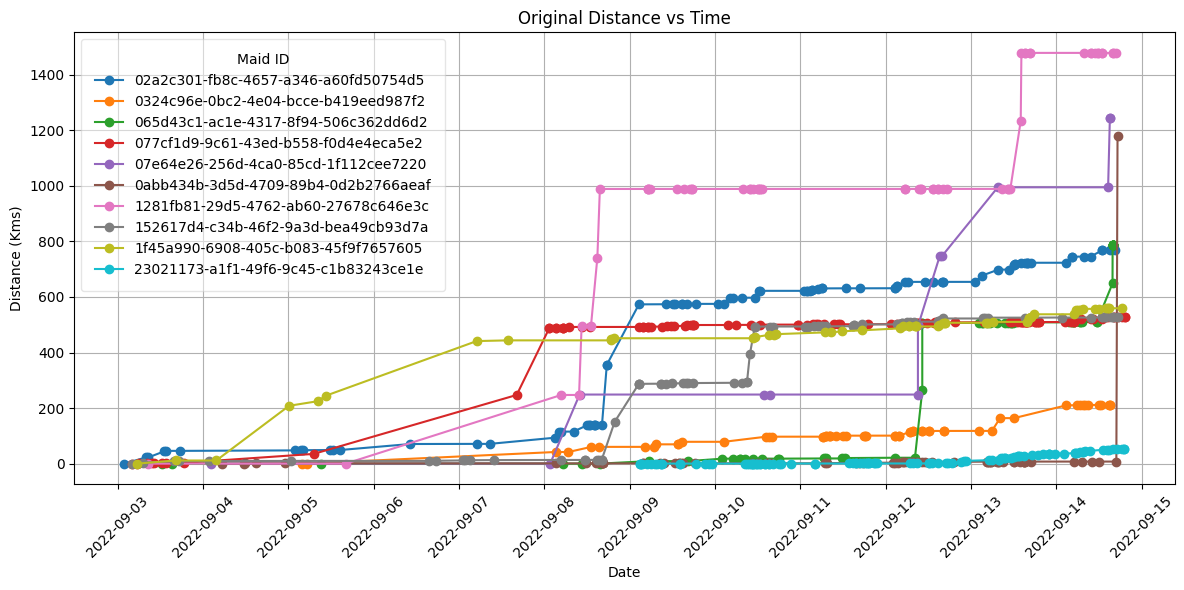

Processing each maid: 100%|██████████| 10/10 [00:00<00:00, 1206.26it/s]

data_new_ shape after filtering out invalid records step 6: (697, 14)


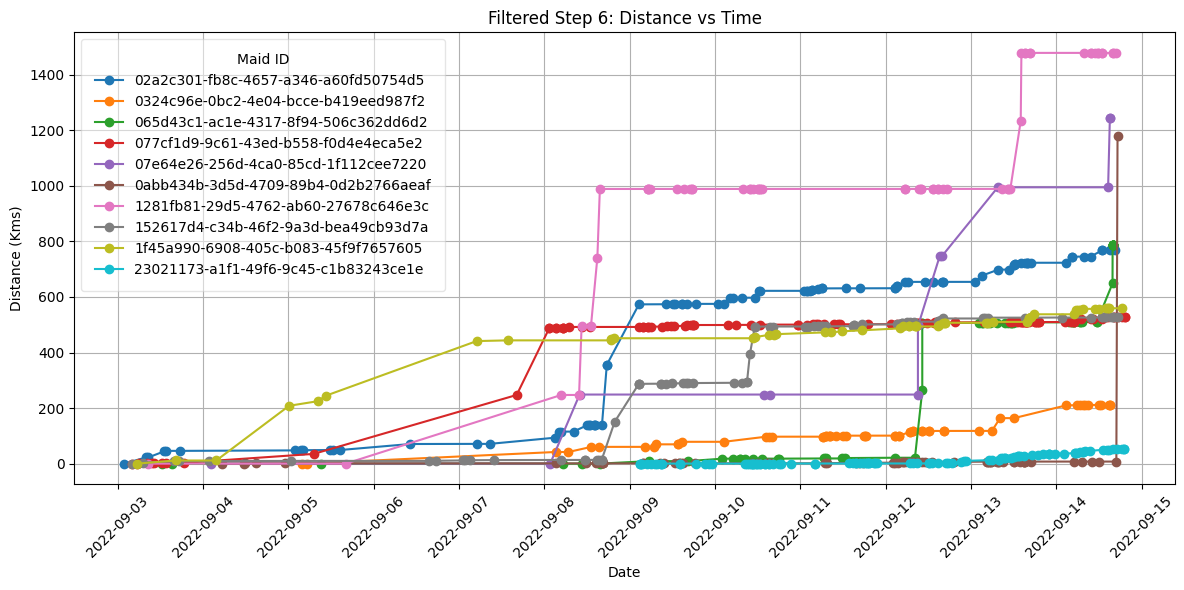

In [38]:
step=6
displacement_min_threshold, min_velocity_threshold, dist_prev_next_threshold, time_gap_pre_next_threshold, sub_folder_name =params(step)
print(f'data_new.shape before filtering invalid stamps : {data_new.shape}')
plot_cumulative_distance(data_new ,'Original')

# data_new.to_excel(fr'{folder_path}\data_{folder_name}.xlsx',index=False)  #save_original_dataframe

# state validity_of_records
data_new = calculate_distances_and_time_gaps_continous_invalid_stamps(data_new, displacement_min_threshold , min_velocity_threshold,time_gap_pre_next_threshold, dist_prev_next_threshold  )  #dataframe, displacement(km), velocity(kmph)
# data_new = calculate_distances_and_time_gaps_continous_invalid_stamps_vector(data_new, displacement_min_threshold , min_velocity_threshold,time_gap_pre_next_threshold, dist_prev_next_threshold  ) 
# data_new.to_excel(fr'{folder_path}\data_stg_1_step_6_{folder_name}.xlsx',index=False)  #save datframe processed at stage 1

data_new = filter_out_continuos_invalid_stamps(data_new)  # dataframe, distance_between previpus and next(km), time(minutes)
print(f'data_new_ shape after filtering out invalid records step {step}: {data_new.shape}')

data_new = optimized_function_maid_vectorized(data_new)


plot_cumulative_distance(data_new, f'Filtered Step {step}:')
# data_new.to_excel(fr'{folder_path}\data_filtered_out_step_6_{folder_name}.xlsx',index=False)  # save dataframe after filtering out individual records


In [34]:
# diff = data_new_without_vectorized.compare(data_new_with_vectorized)
data_new_with_vectorized.shape #(718, 14)
data_new_without_vectorized.shape # (718, 14)

import pandas as pd

def compare_dataframes(df1, df2):
    # Reset index to ensure 'maid' is not an index level
    df1_reset_index = df1.reset_index(drop=True)
    df2_reset_index = df2.reset_index(drop=True)

    # Step 1: Sort both DataFrames
    df1_sorted = df1_reset_index.sort_values(by=df1_reset_index.columns.tolist()).reset_index(drop=True)
    df2_sorted = df2_reset_index.sort_values(by=df2_reset_index.columns.tolist()).reset_index(drop=True)

    # Step 2: Reset index again to ensure proper alignment
    df1_reset = df1_sorted.reset_index(drop=True)
    df2_reset = df2_sorted.reset_index(drop=True)

    # Step 3: Check if DataFrames are equal
    if df1_reset.equals(df2_reset):
        print("The DataFrames are identical.")
    else:
        print("The DataFrames are not identical.")

    # Step 4: Identify differences
    differences = df1_reset.compare(df2_reset)
    if not differences.empty:
        print("Differences found between the DataFrames:")
        print(differences)
    else:
        print("No differences found between the DataFrames.")

    return differences



# Call the function to compare DataFrames
differences = compare_dataframes(data_new_with_vectorized, data_new_without_vectorized)

# Print the differences
print(differences)
data_new_with_vectorized.head()

The DataFrames are not identical.
Differences found between the DataFrames:
    dist_previous_next       time_gap_previous_next       next_valid_index  \
                  self other                   self other             self   
1            22.128688  None             399.783333  None              NaN   
2            22.119788  None             312.950000  None              NaN   
3            22.786519  None             305.850000  None              NaN   
4             1.723913  None             273.833333  None              NaN   
5             1.696727  None            2173.466667  None              NaN   
..                 ...   ...                    ...   ...              ...   
712           1.926031  None             130.083333  None              NaN   
713         972.724806  None              73.700000  None              NaN   
714           0.000000  None              92.450000  None            716.0   
715         972.739402  None             107.166667  None         

maid  \
maid                                                                           
02a2c301-fb8c-4657-a346-a60fd50754d5 0  02a2c301-fb8c-4657-a346-a60fd50754d5   
                                     1  02a2c301-fb8c-4657-a346-a60fd50754d5   
                                     2  02a2c301-fb8c-4657-a346-a60fd50754d5   
                                     3  02a2c301-fb8c-4657-a346-a60fd50754d5   
                                     4  02a2c301-fb8c-4657-a346-a60fd50754d5   

                                                  datetime  latitude  \
maid                                                                   
02a2c301-fb8c-4657-a346-a60fd50754d5 0 2022-09-03 01:50:36   30.0206   
                                     1 2022-09-03 07:49:50   30.1236   
                                     2 2022-09-03 08:30:23   30.1236   
                                     3 2022-09-03 13:02:47   30.0209   
                                     4 2022-09-03 13:36:14   30.0056   

                                        longitude  displacement   distance  \
maid                                                                         
02a2c301-fb8c-4657-a346-a60fd50754d5 0    77.4748      0.000000   0.000000   
                                     1    77.2782     22.115073  22.115073   
                                     2    77.2782      0.000000  22.115073   
                                     3    77.4749     22.106030  44.221103   
                                     4    77.4717      1.728958  45.950061   

                                        cumulative_time(minutes)  Velocity  \
maid                                                                         
02a2c301-fb8c-4657-a346-a60fd50754d5 0                  0.000000  0.000000   
                                     1                359.233333  3.693712   
                                     2                399.783333  0.000000   
                                     3                672.183333  4.869170   
                                     4                705.633333  3.101269   

                                                state district  \
maid                                                             
02a2c301-fb8c-4657-a346-a60fd50754d5 0  Uttar Pradesh  Outside   
                                     1        Haryana  Outside   
                                     2        Haryana  Outside   
                                     3  Uttar Pradesh  Outside   
                                     4  Uttar Pradesh  Outside   

                                        dist_previous_next  \
maid                                                         
02a2c301-fb8c-4657-a346-a60fd50754d5 0                 NaN   
                                     1           22.128688   
                                     2           22.119788   
                                     3           22.786519   
                                     4            1.723913   

                                        time_gap_previous_next  \
maid                                                             
02a2c301-fb8c-4657-a346-a60fd50754d5 0                     NaN   
                                     1              399.783333   
                                     2              312.950000   
                                     3              305.850000   
                                     4              273.833333   

                                        next_valid_index  keep  
maid                                                            
02a2c301-fb8c-4657-a346-a60fd50754d5 0               NaN  True  
                                     1               NaN  True  
                                     2               NaN  True  
                                     3               NaN  True  
                                     4               NaN  True

In [177]:
step_count = int(input())

In [178]:
count=1
folder_for_filtered_records= os.path.join(base_path, f'Trial_{count}\{step_count}_{sub_folder_name}')
create_directory(folder_for_filtered_records)

# folder_for_filtered_records = os.path.join(folder_for_filtered_records, f'')
path_individual_filtered_rec = os.path.join(folder_for_filtered_records, 'filtered_rec')
path_position_time_plots_filtered = os.path.join(folder_for_filtered_records, 'filtered_pos_time')
create_directory(path_individual_filtered_rec)
create_directory(path_position_time_plots_filtered)

grouped = data_new.groupby('maid')
for maid, group in grouped:
    group['datetime']= pd.to_datetime(group['datetime'])
    group=group.sort_values(by=['datetime'])
    group.to_csv(fr'{path_individual_filtered_rec}\filt_{maid}.csv', index=False)
    group.to_excel(fr'{path_individual_filtered_rec}\filt_{maid}.xlsx', index=False)
    shapefile_path = r'C:\Users\User\Downloads\Mobility_traces_new_data_code\GeoJSON files\India\Indian_States.shp'
    save_path = fr'{path_position_time_plots_filtered}\pos_time_filt_{maid}.html'
    create_position_time(group, shapefile_path,save_path )

In [180]:
data_new_filtered_stepwise = data_new  #track of records processed and filtered out step by step

In [201]:
data_new_filtered_stepwise=data_new_filtered_stepwise.sort_values(by=['maid','datetime','latitude','longitude']).reset_index()

In [202]:
data_new_single_big_step_process=data_new_single_big_step_process.sort_values(by=['maid','datetime','latitude','longitude']).reset_index()

In [205]:
# diff= data_new_filtered_stepwise.compare(data_new_single_big_step_process)
# len(diff)
data_new_filtered_stepwise.shape #(697, 15)
data_new_single_big_step_process.shape #(682, 15)

(682, 15)

In [207]:
# Merge with indicator to find rows in df1 but not in df2
df2= data_new_single_big_step_process.copy()
df1=data_new_filtered_stepwise.copy()
merged_df = df1.merge(df2, on=['maid', 'datetime', 'latitude', 'longitude'], how='outer', indicator=True)
difference = merged_df[merged_df['_merge'] == 'left_only']
len(difference)

15

In [55]:
# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Disable line wrapping
# pd.set_option('display.max_colwidth', None)  # Show full column content
# print(data_new['time_gap_previous_next'].sum() ==0 )
# print(data_new[data_new['dist_previous_next'].notna()].shape)
# data_new_prev = pd.read_csv(r'C:\Users\User\Downloads\Mobility_traces_new_data_code\validating_records\bad_and_good_ids_0_10_filtered.csv')
# data_new.to_csv(r'C:\Users\User\Downloads\Mobility_traces_new_data_code\validating_records\bad_and_good_ids_0_10_filtered_3.csv', index=False)
# data_new['time_gap_previous_next']
data_new.to_excel(r'C:\Users\User\Downloads\Mobility_traces_new_data_code\validating_records\data_id_10_15_filtered_twice.xlsx', index=False) #original

In [1]:
import pandas as pd
from geopy.distance import geodesic
from tqdm import tqdm
#code to find the transition for displacements within a range from displacement_min to displacement_max
def calculate_distances_and_time_gaps_continous_invalid_stamps_with_disp_limitation(data, displacement_min, displacement_max, velocity_threshold, time_window, distance_range):
    # Convert 'datetime' column to datetime format
    data['datetime'] = pd.to_datetime(data['datetime'])
    # col_name = f'keep_for_{displacement_threshold}_{velocity_threshold}_{time_window}_{distance_range}'
    # Initialize new columns
    data['dist_previous_next'] = None
    data['time_gap_previous_next'] = None
    data['next_valid_index'] = None
    data['keep'] = True
    
    # Sort data by 'maid', 'datetime', 'latitude', and 'longitude', and reset index
    data = data.sort_values(by=['maid', 'datetime', 'latitude', 'longitude']).reset_index(drop=True)
    
    # Maintain a mapping from the original index to the new sorted index
    original_to_sorted_index = data.reset_index().set_index('index').index
    # Initialize the progress bar
    tqdm.pandas(desc="Processing maids")

    # Calculate distance and time gap
    for maid, group in tqdm(data.groupby('maid'), desc="Processing each maid"):
    # Calculate distance and time gap
    # for maid, group in data.groupby('maid'):
        num_records = len(group)
        for i in range(1, num_records - 1):
        # for i in range(1, num_records - 1):
            displacement = group.loc[group.index[i], 'displacement']
            # print(f'group.index[i]: {group.index[i]}')
            # print(f'disalcement:{displacement}')
            velocity = group.loc[group.index[i], 'Velocity']
            # print(f'disalcement:{displacement}, velocity { {velocity}}')
            if (displacement >= displacement_min) and (displacement<=displacement_max) and (velocity >= velocity_threshold):
                # print(f'Inside if: disalcement:{displacement}, velocity { {velocity}}')
                # print(f'index: {group.index[i]}')
                prev_record = group.loc[group.index[i - 1]]
                next_valid_index = None
                
                for j in range(i + 1, num_records):
                    next_record = group.loc[group.index[j]]
                    time_gap = (next_record['datetime'] - prev_record['datetime']).total_seconds() / 60
                    
                    if time_gap > time_window:
                        break
                    
                    distance = geodesic(
                        (prev_record['latitude'], prev_record['longitude']),
                        (next_record['latitude'], next_record['longitude'])
                    ).kilometers
                    
                    if distance < distance_range:
                        next_valid_index = j
                        break

                if next_valid_index is not None:
                    original_index = group.index[i]
                    sorted_next_valid_index = group.index[next_valid_index]

                    # Convert sorted index back to original index
                    original_next_valid_index = original_to_sorted_index.get_loc(sorted_next_valid_index)

                    # Update the current record (i) with information about the next valid index
                    data.at[original_index, 'next_valid_index'] = original_next_valid_index
                    data.at[original_index, 'dist_previous_next'] = distance
                    data.at[original_index, 'time_gap_previous_next'] = time_gap

                    # Mark records between the current index and one record before the next valid index as False
                    if original_next_valid_index > original_index:
                        indices_to_mark = range(original_index , original_next_valid_index)
                        data.loc[indices_to_mark, 'keep'] = False

    return data

def filter_out_continuos_invalid_stamps(data):
    filtered_data = data[data['keep'] == True]
    return filtered_data

In [ ]:
data_dist_without_type_1

In [17]:
# data_dist_without_vel_150_disp_50 = data_dist_without_vel_150_disp_50.sort_values(by=['maid','datetime','latitude','longitude'])
# data_dist_with_info_of_smaller_displacements= calculate_distances_and_time_gaps_continous_invalid_stamps_with_disp_limitation(data_dist_without_vel_150_disp_50,10,25, 100,15,15 )
# data_dist_with_info_of_smaller_displacements[data_dist_with_info_of_smaller_displacements['keep']==False]['maid'].count()

# df_all_with_info_of_smaller_displacements= calculate_distances_and_time_gaps_continous_invalid_stamps_with_disp_limitation(df_all,25,50, 100,30,25 )
x= df_all_with_info_of_smaller_displacements[df_all_with_info_of_smaller_displacements['keep']==False]
x['maid'].count()


np.int64(1834)

In [16]:
rec_with_velocity_500 = df_all[df_all['Velocity']>=500]
rec_with_velocity_500['maid'].nunique()

63083

In [ ]:
rec_with_velocity_400 = data_dist[data_dist['Velocity']>=400]
rec_with_velocity_400['maid'].nunique()

81437

In [ ]:
rec_with_velocity_300 = data_dist[data_dist['Velocity']>=300]
rec_with_velocity_300['maid'].nunique()

82319

In [ ]:
rec_with_velocity_200 = data_dist[data_dist['Velocity']>=200]
rec_with_velocity_200['maid'].nunique()

83857

In [14]:
df_all=pd.read_csv(r'C:\Users\User\Downloads\Mobility_traces_new_data_code\all visitors\all_visitors.csv')

In [18]:
# df_all['latitude']=df_all['latitude'].astype(float).round(4)
# df_all['longitude'] = df_all['longitude'].astype(float).round(4)
print(f'df_all.shape : {df_all.shape}')  #(19096604, 5) # 140180 uique IDs
# df_all_stage1 = remove_unnecessary_timestamps(df_all)
print(f'df_all_stage1.shape: {df_all_stage1.shape}') # (4554069, 5)  #134316 unique IDs, no single timestamp for each ID
# finding records with single occurrence
maid_counts = df_all_stage1['maid'].value_counts()
distinct_ids = df_all_stage1['maid'].nunique()
print(f'maid distinct counts:  {distinct_ids} ')
maid_single_records = maid_counts[maid_counts == 1].index
print(f' number of IDs with single time stamp: {len(maid_single_records)}')
# maid_single_records
# Convert datetime column to datetime type
df_all_stage1['datetime'] = pd.to_datetime(df_all_stage1['datetime'])

# Remove duplicates based on maid, datetime, latitude, and longitude, keeping the first occurrence
df_all_stage2 = df_all_stage1.drop_duplicates(subset=['maid', 'datetime', 'latitude', 'longitude'], keep='first')
print(f'df_all_stage1.shape: {df_all_stage2.shape}')  #(3729555, 5)  ##134316 unique IDs , 3164 with single time stamps
maid_counts = df_all_stage2['maid'].value_counts()
maid_single_records = maid_counts[maid_counts == 1].index
# len(maid_single_records)
# print(f'maid_counts_1 {maid_counts} ')
# maid_single_records = maid_counts[maid_counts == 1].index
print(f' number of IDs with single time stamp: {len(maid_single_records)}')

#deleteing duplicates first from df_all
# df_all['datetime']=pd.to_datetime(df_all['datetime'])
# df_all= df_all.sort_values(by=['maid','datetime','latitude','longitude'])
# df_all_new_way_stage1 = df_all.drop_duplicates(subset=['maid', 'datetime', 'latitude', 'longitude'], keep='first')
# print(df_all_new_way_stage1.shape) # (6323096, 5)
# print(df_all_new_way_stage1['maid'].nunique()) # 140180, 9028 having single timestamp
# maid_counts = df_all_new_way_stage1['maid'].value_counts()
# maid_single_records = maid_counts[maid_counts == 1].index
# print(len(maid_single_records))  

#removing unnecessary time stamps from df_all_new_way_stage1
# df_all_new_way_stage2 = remove_unnecessary_timestamps(df_all_new_way_stage1)
# print(df_all_new_way_stage2.shape) # (3726391, 5)
# print(df_all_new_way_stage2['maid'].nunique()) # 131152, 0 having single timestamp
# maid_counts = df_all_new_way_stage2['maid'].value_counts()
# maid_single_records = maid_counts[maid_counts == 1].index
# print(len(maid_single_records))  




df_all.shape : (19096604, 5)
df_all_stage1.shape: (4554069, 5)
maid distinct counts:  134316 
 number of IDs with single time stamp: 0
df_all_stage1.shape: (3729555, 5)
 number of IDs with single time stamp: 3164


In [2]:
df_all_new_way_stage1.shape

NameError: name 'df_all_new_way_stage1' is not defined

In [ ]:
# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Disable line wrapping
pd.set_option('display.max_colwidth', None)  # Show full column content
# Set display option to avoid scientific notation
pd.set_option('display.float_format', '{:.3f}'.format)
bad_id = {'9df511c8-28ff-4a53-b223-8bf2ff667a55', '31354cf8-1d79-429b-866b-b5c0446cfd07', '02a2c301-fb8c-4657-a346-a60fd50754d5'}
data__ = data_dist[data_dist['maid'].isin(bad_id)] # 67b8dd2a-9f8c-4949-8e44-87c923f450f5
# data_dist_sample_id.columns
# Ensure datetime column is in datetime format
data__['datetime'] = pd.to_datetime(data__['datetime'], format='%Y-%m-%d %H:%M:%S')

# Initialize new columns
data__['dist_previous_next'] = None
data__['time_gap_previous_next'] = None

# Calculate distance and time gap
for maid, group in data__.groupby('maid'):
    for i in range(1, len(group) - 1):  # Start from 1 to len-1 to avoid out-of-bounds
        if (group.iloc[i]['displacement'] >= 100) and (group.iloc[i]['Velocity'] >= 400):
            # Previous and next records
            prev_record = group.iloc[i - 1]
            next_record = group.iloc[i + 1]
            
            # Calculate distance using Haversine
            distance = geodesic(
                (prev_record['latitude'], prev_record['longitude']),
                (next_record['latitude'], next_record['longitude'])
            ).kilometers
            
            # Calculate time gap in minutes
            time_gap = (next_record['datetime'] - prev_record['datetime']).total_seconds() / 60
            
            # Update the original DataFrame
            data__.loc[group.index[i], 'dist_previous_next'] = distance
            data__.loc[group.index[i], 'time_gap_previous_next'] = time_gap

# data__[['maid','datetime','latitude','longitude','displacement','Velocity','dist_previous_next','time_gap_previous_next']].to_excel(r'C:\Users\User\Downloads\Mobility_traces_new_data_code\validating_records\data__1.xlsx', index=False)

data__= data__[['maid','datetime','latitude','longitude','distance','displacement','Velocity','dist_previous_next','time_gap_previous_next']]
# x = data_dist[data_dist['maid'].str.startswith('67b8dd')]
# x['maid'].unique()
# data_dist_sample_id_1